1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Currently processing 0 / 400
Cost and accuracy 2.5063406691816548 0.1175
Currently processing 1 / 400
Currently processing 2 / 400
Currently processing 3 / 400
Currently processing 4 / 400
Currently processing 5 / 400
Currently processing 6 / 400
Currently processing 7 / 400
Currently processing 8 / 400
Currently processing 9 / 400
Currently processing 10 / 400
Currently processing 11 / 400
Currently processing 12 / 400
Currently processing 13 / 400
Currently processing 14 / 400
Currently processing 15 / 400
Currently processing 16 / 400
Currently processing 17 / 400
Currently processing 18 / 400
Currently processing 19 / 400
Currently processing 20 / 400
Currently processing 21 / 400
Currently processing 22 / 400
Currently processing 23 / 400
Currently processing 24 / 400
Currently processing 25 / 400
Currently processing 26 / 400
Currently processing 27 / 4

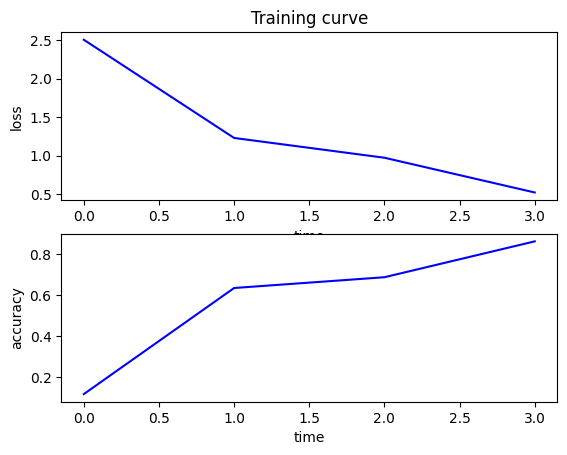

In [11]:
from google.colab import drive
drive.mount('/content/drive')
!pip install datasets
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import math

MAX_POOL_SIZE = 5
CONVOLUTION_SIZE = 4
CONVOLUTION_FILTERS = 2

def forward_softmax(x):
    """
    Compute softmax function for a single example.
    The shape of the input is of size # num classes.
    Important Note: You must be careful to avoid overflow for this function. Functions
    like softmax have a tendency to overflow when very large numbers like e^10000 are computed.
    You will know that your function is overflow resistent when it can handle input like:
    np.array([[10000, 10010, 10]]) without issues.
    Args:
        x: A 1d numpy float array of shape number_of_classes
    Returns:
        A 1d numpy float array containing the softmax results of shape  number_of_classes
    """
    x = x - np.max(x,axis=0)
    exp = np.exp(x)
    s = exp / np.sum(exp,axis=0)
    return s

def backward_softmax(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x.
    grad_outputs is the gradient of the loss with respect to the outputs of the softmax.
    Args:
        x: A 1d numpy float array of shape number_of_classes
        grad_outputs: A 1d numpy float array of shape number_of_classes
    Returns:
        A 1d numpy float array of the same shape as x with the derivative of the loss with respect to x
    """
    # *** START CODE HERE ***
    """
    D_{ii} = \sigma(z)_i(1-\sigma(z)_i) and D_{ij} = -\sigma(z)_i\sigma(z)_j for i\neq j
    In other words, D = -\sigma(z)\sigma(z)^T + diag(\sigma(z))
    """
    sigma_z = forward_softmax(x)
    differential = - np.outer(sigma_z, sigma_z)
    differential += np.diag(sigma_z)
    return differential.T @ grad_outputs
    # *** END CODE HERE ***

def forward_relu(x):
    """
    Compute the relu function for the input x.
    Args:
        x: A numpy float array
    Returns:
        A numpy float array containing the relu results
    """
    x[x<=0] = 0
    return x

def backward_relu(x, grad_outputs):
    """
    Compute the gradient of the loss with respect to x
    Args:
        x: A numpy array of arbitrary shape containing the input.
        grad_outputs: A numpy array of the same shape of x containing the gradient of the loss with respect
            to the output of relu
    Returns:
        A numpy array of the same shape as x containing the gradients with respect to x.
    """
    # *** START CODE HERE ***
    """
    D_{i,i} = 1(x>0)
    """
    differential = (x > 0).astype(int)
    return differential * grad_outputs
    # *** END CODE HERE ***

def get_initial_params():
    """
    Compute the initial parameters for the neural network.
    This function should return a dictionary mapping parameter names to numpy arrays containing
    the initial values for those parameters.
    There should be four parameters for this model:
    W1 is the weight matrix for the convolutional layer
    b1 is the bias vector for the convolutional layer
    W2 is the weight matrix for the output layers
    b2 is the bias vector for the output layer
    Weight matrices should be initialized with values drawn from a random normal distribution.
    The mean of that distribution should be 0.
    The variance of that distribution should be 1/sqrt(n) where n is the number of neurons that
    feed into an output for that layer.
    Bias vectors should be initialized with zero.
    Returns:
        A dict mapping parameter names to numpy arrays
    """
    size_after_convolution = 28 - CONVOLUTION_SIZE + 1
    size_after_max_pooling = size_after_convolution // MAX_POOL_SIZE
    num_hidden = size_after_max_pooling * size_after_max_pooling * CONVOLUTION_FILTERS
    return {
        'W1': np.random.normal(size = (CONVOLUTION_FILTERS, 1, CONVOLUTION_SIZE, CONVOLUTION_SIZE), scale=1/ math.sqrt(CONVOLUTION_SIZE * CONVOLUTION_SIZE)),
        'b1': np.zeros(CONVOLUTION_FILTERS),
        'W2': np.random.normal(size = (num_hidden, 10), scale = 1/ math.sqrt(num_hidden)),
        'b2': np.zeros(10)
    }

def forward_convolution(conv_W, conv_b, data):
    """
    Compute the output from a convolutional layer given the weights and data.
    conv_W is of the shape (# output channels, # input channels, convolution width, convolution height )
    conv_b is of the shape (# output channels)
    data is of the shape (# input channels, width, height)
    The output should be the result of a convolution and should be of the size:
        (# output channels, width - convolution width + 1, height -  convolution height + 1)
    Returns:
        The output of the convolution as a numpy array
    """
    conv_channels, _, conv_width, conv_height = conv_W.shape
    input_channels, input_width, input_height = data.shape
    output = np.zeros((conv_channels, input_width - conv_width + 1, input_height - conv_height + 1))
    for x in range(input_width - conv_width + 1):
        for y in range(input_height - conv_height + 1):
            for output_channel in range(conv_channels):
                output[output_channel, x, y] = np.sum(
                    np.multiply(data[:, x:(x + conv_width), y:(y + conv_height)], conv_W[output_channel, :, :, :])) + conv_b[output_channel]
    return output

def backward_convolution(conv_W, conv_b, data, output_grad):
    """
    Compute the gradient of the loss with respect to the parameters of the convolution.
    See forward_convolution for the sizes of the arguments.
    output_grad is the gradient of the loss with respect to the output of the convolution.
    Args:
        conv_W: of the shape (O, I, W, H)
        conv_b: of the shape (O)
        data: of the shape (I, X, Y)
        output_grad: of the shape (O, X - W + 1, Y - H + 1)
    Returns:
        A tuple containing 3 gradients.
        The first element is the gradient of the loss with respect to the convolution weights
        The second element is the gradient of the loss with respect to the convolution bias
        The third element is the gradient of the loss with respect to the input data
    """
    # *** START CODE HERE ***
    """
    for 0 <= x < X - W + 1, 0 <= y < Y - H + 1, output[o, x, y] = conv_b[o] + \sum_{0 <= dx < W, 0 <= dy < H, i}data[i, x+dx, y+dy] * conv_W[o, i, dx, dy]
    \partial J / \partial conv_W[o, i, dx, dy] = \sum_{0 <= x < X - W + 1, 0 <= y < Y - H + 1]} output_grad[o, x, y] * data[i, x + dx, y + dy]
    """
    O, I, W, H = conv_W.shape
    _, X, Y = data.shape
    differential_preprocess = output_grad[None, :, :, :, None, None] * data[:, None, None, None, :, :]
    # differential_preprocess.shape == [I, O, X - W + 1, Y - H + 1, X, Y]; output_grad.shape == [O, X - W + 1, Y - H + 1]; data.shape == (I, X, Y)
    differential_preprocess2 = np.zeros((I, O, X - W + 1, Y - H + 1, W, H))
    for x in range(X - W + 1):
      for y in range(Y - H + 1):
        differential_preprocess2[:, :, x, y, :, :] = differential_preprocess[:, :, x, y, x:x+W, y:y+H]
    # differential_masked[i, o, x, y, w, h] = differential_preprocess[i, o, x, y, x + w, y + h];
    differential_conv_W = np.sum(differential_preprocess2, axis=(-4, -3))
    differential_conv_W = np.transpose(differential_conv_W, (1, 0, 2, 3))
    """
    \partial J / \partial conv_b[o] = \sum_{0 <= x < X - W + 1, 0 <= y < Y - H + 1} output_grad[o, x, y]
    """
    differential_conv_b = np.sum(output_grad, axis=(-2, -1))
    """
    \partial J / \partial data[i, x, y] = \sum_{o in O, 0 <= dx < \min\{x, W\}, 0 <= dy < \min\{y, H\}}output_grad[o, x - dx, y - dy] * conv_W[o, i, dx, dy]
    """
    differential_data = np.zeros(data.shape)
    for x in range(X - W + 1):
      for y in range(Y - H + 1):
          for o in range(O):
            differential_data[:, x:(x + W), y:(y + H)] +=  conv_W[o, :, :, :] * output_grad[o, x, y]
    return (differential_conv_W, differential_conv_b, differential_data)
    # *** END CODE HERE ***

def forward_max_pool(data, pool_width, pool_height):
    # this function works only when pool_width and pool_height divide width and height of data
    """
    Compute the output from a max pooling layer given the data and pool dimensions.
    The stride length should be equal to the pool size
    data is of the shape (# channels, width, height)
    The output should be the result of the max pooling layer and should be of size:
        (# channels, width // pool_width, height // pool_height)
    Returns:
        The result of the max pooling layer
    """
    input_channels, input_width, input_height = data.shape
    output = np.zeros((input_channels, input_width // pool_width, input_height // pool_height))
    for x in range(0, input_width, pool_width):
        for y in range(0, input_height, pool_height):
            output[:, x // pool_width, y // pool_height] = np.amax(data[:, x:(x + pool_width), y:(y + pool_height)], axis=(1, 2))
    return output

def backward_max_pool(data, pool_width, pool_height, output_grad):
    """
    Compute the gradient of the loss with respect to the data in the max pooling layer.
    data is of the shape (# channels, width, height)
    output_grad is of shape (# channels, width // pool_width, height // pool_height)
    output_grad is the gradient of the loss with respect to the output of the backward max
    pool layer.
    Returns:
        The gradient of the loss with respect to the data (of same shape as data)
    """
    # *** START CODE HERE ***
    differential_data = np.zeros(data.shape)
    for x in range(0, data.shape[1], pool_width):
      for y in range(0, data.shape[2], pool_height):
        for i in range(data.shape[0]):
          array = data[i, x:(x + pool_width), y:(y + pool_height)]
          global_max_index = np.argmax(array)
          row_index, col_index = np.unravel_index(global_max_index, array.shape)
          differential_data[i, x + row_index, y + col_index] = output_grad[i, x // pool_width, y // pool_height]
    return differential_data
    # *** END CODE HERE ***

def forward_cross_entropy_loss(probabilities, labels):
    """
    Compute the output from a cross entropy loss layer given the probabilities and labels.
    probabilities is of the shape (# classes)
    labels is of the shape (# classes)
    The output should be a scalar
    Returns:
        The result of the log loss layer
    """
    result = 0
    for i, label in enumerate(labels):
        if label == 1:
            result += -np.log(probabilities[i])
    return result

def backward_cross_entropy_loss(probabilities, labels):
    """
    Compute the gradient of the cross entropy loss with respect to the probabilities.
    probabilities is of the shape (# classes)
    labels is of the shape (# classes)
    The output should be the gradient with respect to the probabilities.
    Returns:
        The gradient of the loss with respect to the probabilities.
    """
    # *** START CODE HERE ***
    """
    differential_probabilities[i] = labels[i] * (- 1 / probabilities[i])
    """
    y_pred = np.clip(probabilities, 1e-12, 1)
    return - labels / y_pred
    # *** END CODE HERE ***

def forward_linear(weights, bias, data):
    """
    Compute the output from a linear layer with the given weights, bias and data.
    weights is of the shape (input # features, output # features)
    bias is of the shape (output # features)
    data is of the shape (input # features)
    The output should be of the shape (output # features)
    Returns:
        The result of the linear layer
    """
    return data.dot(weights) + bias

def backward_linear(weights, bias, data, output_grad):
    """
    Compute the gradients of the loss with respect to the parameters of a linear layer.
    See forward_linear for information about the shapes of the variables.
    output_grad is the gradient of the loss with respect to the output of this layer.
    This should return a tuple with three elements:
    - The gradient of the loss with respect to the weights
    - The gradient of the loss with respect to the bias
    - The gradient of the loss with respect to the data
    """
    # *** START CODE HERE ***
    """
    differential_weights[i, j] = data[i] * output_grad[j]
    """
    differential_weights = data[:, None] * output_grad[None, :]
    """
    differential_bias[i] = output_grad[i]
    """
    differential_bias = output_grad
    """
    differential_data[i] = \sum_j weights[i, j] * output_grad[j]
    """
    differential_data = weights @ output_grad
    return (differential_weights, differential_bias, differential_data)
    # *** END CODE HERE ***

def forward_prop(data, labels, params):
    """
    Implement the forward layer given the data, labels, and params.
    Args:
        data: A numpy array containing the input (shape is 1 by 28 by 28)
        labels: A 1d numpy array containing the labels (shape is 10)
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network
    Returns:
        A 2 element tuple containing:
            1. A numpy array The output (after the softmax) of the output layer
            2. The average loss for these data elements
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)
    flattened = np.reshape(first_after_relu, (-1))
    logits = forward_linear(W2, b2, flattened)
    y = forward_softmax(logits)
    cost = forward_cross_entropy_loss(y, labels)
    return y, cost

def backward_prop(data, labels, params):
    """
    Implement the backward propagation gradient computation step for a neural network
    Args:
        data: A numpy array containing the input for a single example
        labels: A 1d numpy array containing the labels for a single example
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2, and b2
            W1 and b1 represent the weights and bias for the convolutional layer
            W2 and b2 represent the weights and bias for the output layer of the network
    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.
        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    # *** START CODE HERE ***
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']
    first_convolution = forward_convolution(W1, b1, data)
    first_max_pool = forward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE)
    first_after_relu = forward_relu(first_max_pool)
    flattened = np.reshape(first_after_relu, (-1))
    logits = forward_linear(W2, b2, flattened)
    probabilities = forward_softmax(logits)
    cost = forward_cross_entropy_loss(probabilities, labels)
    # print("cost = " + str(cost))
    differential_probabilities = backward_cross_entropy_loss(probabilities, labels)
    # print("differential_probabilities mean=" + str(np.mean(differential_probabilities)))
    differential_logits = backward_softmax(logits, differential_probabilities)
    # print("differential_logits mean=" + str(np.mean(differential_logits)))
    differential_W2, differential_b2, differential_flattened = backward_linear(W2, b2, flattened, differential_logits)
    # print("differential_W2 mean=" + str(np.mean(differential_W2)) + "; differential_b2 mean=" + str(np.mean(differential_b2)) + " differential_flattened mean=" + str(np.mean(differential_flattened)))
    differential_first_after_relu = np.reshape(differential_flattened, first_after_relu.shape)
    # print("differential_first_after_relu mean=" + str(np.mean(differential_first_after_relu)))
    differential_first_max_pool = backward_relu(first_max_pool, differential_first_after_relu)
    # print("differential_first_max_pool mean=" + str(np.mean(differential_first_max_pool)))
    differential_first_convolution = backward_max_pool(first_convolution, MAX_POOL_SIZE, MAX_POOL_SIZE, differential_first_max_pool)
    # print("differential_first_convolution mean=" + str(np.mean(differential_first_convolution)))
    differential_W1, differential_b1, differential_data = backward_convolution(W1, b1, data, differential_first_convolution)
    #print("differential_W1 mean=" + str(np.mean(differential_W1)) + " differential_b1 mean=" + str(np.mean(differential_b1)) + " differential_data mean=" + str(np.mean(differential_data)))
    return {"W1" : differential_W1, "W2" : differential_W2, "b1" : differential_b1, "b2" : differential_b2}
    # *** END CODE HERE ***

def forward_prop_batch(batch_data, batch_labels, params, forward_prop_func):
    """Apply the forward prop func to every image in a batch"""
    y_array = []
    cost_array = []
    for item, label in zip(batch_data, batch_labels):
        y, cost = forward_prop_func(item, label, params)
        y_array.append(y)
        cost_array.append(cost)
    return np.array(y_array), np.array(cost_array)

def gradient_descent_batch(batch_data, batch_labels, learning_rate, params, backward_prop_func):
    """
    Perform one batch of gradient descent on the given training data using the provided learning rate.
    This code should update the parameters stored in params.
    It should not return anything
    Args:
        batch_data: A numpy array containing the training data for the batch
        train_labels: A numpy array containing the training labels for the batch
        learning_rate: The learning rate
        params: A dict of parameter names to parameter values that should be updated.
        backward_prop_func: A function that follows the backwards_prop API
    Returns: This function returns nothing.
    """
    total_grad = {}
    for i in range(batch_data.shape[0]):
        grad = backward_prop_func(
            batch_data[i, :, :],
            batch_labels[i, :],
            params)
        for key, value in grad.items():
            if key not in total_grad:
                total_grad[key] = np.zeros(value.shape)
            total_grad[key] += value
    for key, value in total_grad.items():
      total_grad[key] = total_grad[key] / batch_data.shape[0]
    params['W1'] = params['W1'] - learning_rate * total_grad['W1']
    # print('W1 grad mean=' + str(np.mean(total_grad['W1'])))
    params['W2'] = params['W2'] - learning_rate * total_grad['W2']
    # print('W2 grad mean=' + str(np.mean(total_grad['W2'])))
    params['b1'] = params['b1'] - learning_rate * total_grad['b1']
    # print('b1 grad mean=' + str(np.mean(total_grad['b1'])))
    params['b2'] = params['b2'] - learning_rate * total_grad['b2']
    # print('b2 grad mean=' + str(np.mean(total_grad['b2'])))
    # This function does not return anything
    return

def nn_train(
    train_data, train_labels, dev_data, dev_labels,
    get_initial_params_func, forward_prop_func, backward_prop_func,
    learning_rate=5.0, batch_size=16, num_batches=400):
    m = train_data.shape[0]
    params = get_initial_params_func()
    cost_dev = []
    accuracy_dev = []
    for batch in range(num_batches):
        print('Currently processing {} / {}'.format(batch, num_batches))
        batch_data = train_data[batch * batch_size:(batch + 1) * batch_size, :, :, :]
        batch_labels = train_labels[batch * batch_size: (batch + 1) * batch_size, :]
        if batch % 100 == 0:
            output, cost = forward_prop_batch(dev_data, dev_labels, params, forward_prop_func)
            cost_dev.append(sum(cost) / len(cost))
            accuracy_dev.append(compute_accuracy(output, dev_labels))
            print('Cost and accuracy', cost_dev[-1], accuracy_dev[-1])
        gradient_descent_batch(batch_data, batch_labels,
            learning_rate, params, backward_prop_func)
    return params, cost_dev, accuracy_dev

def nn_test(data, labels, params):
    output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def compute_accuracy(output, labels):
    correct_output = np.argmax(output,axis=1)
    correct_labels = np.argmax(labels,axis=1)
    is_correct = [a == b for a,b in zip(correct_output, correct_labels)]
    accuracy = sum(is_correct) * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

#def read_data(images_file, labels_file):
#    x = np.loadtxt(images_file, delimiter=',')
#    y = np.loadtxt(labels_file, delimiter=',')
#    x = np.reshape(x, (x.shape[0], 1, 28, 28))
#    return x, y

def run_train(all_data, all_labels, backward_prop_func):
    params, cost_dev, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'],
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        learning_rate=3e-1, batch_size=16, num_batches=400
    )
    t = np.arange(400 // 100)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(t, cost_dev, 'b')
    ax1.set_xlabel('time')
    ax1.set_ylabel('loss')
    ax1.set_title('Training curve')
    ax2.plot(t, accuracy_dev, 'b')
    ax2.set_xlabel('time')
    ax2.set_ylabel('accuracy')
    fig.savefig('/content/drive/MyDrive/cs229/problem-sets/PS4/output/train.png')

def main():
    np.random.seed(100)
    ds = load_dataset("ylecun/mnist")
    train_dataset = ds['train']
    train_data = np.array([np.array(sample['image']) for sample in train_dataset])
    train_data = np.reshape(train_data, (train_data.shape[0], 1, 28, 28))
    train_labels = np.array([np.array(sample['label']) for sample in train_dataset])
    # train_data, train_labels = read_data('/content/drive/MyDrive/cs229/problem-sets/PS4/data/images_train.csv', '/content/drive/MyDrive/cs229/problem-sets/PS4/data/labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p,:]
    train_labels = train_labels[p,:]
    dev_data = train_data[0:400,:]
    dev_labels = train_labels[0:400,:]
    train_data = train_data[400:,:]
    train_labels = train_labels[400:,:]
    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std
    all_data = {
        'train': train_data,
        'dev': dev_data,
    }
    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
    }
    run_train(all_data, all_labels, backward_prop)

if __name__ == '__main__':

    main()